In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy

from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from skimage.transform import pyramid_gaussian
from skimage.restoration import unwrap_phase
from scipy.ndimage import center_of_mass

import sscCdi
from sscCdi import unwrap_in_parallel, equalize_frames_parallel, make_bad_frame_null
import sscRadon

%matplotlib widget

In [14]:
### CC ### 

def alignment_variance_field(data, pyramid_downsampling=2, fft_upsampling=10, return_common_valid_region=True, remove_null_borders = True):
    
    _, total_shift = get_shifts_of_local_variance(data,fft_upsampling,pyramid_downsampling)

    # if pyramid_downsampling > 1:
        # total_shift = total_shift*pyramid_downsampling # multiply by downsampling factor
    
    aligned_volume = shift_volume_slices(data,total_shift)
    
    if return_common_valid_region:
        masked_volume = np.where(aligned_volume==0,0,1)
        product = np.prod(np.abs(masked_volume),axis=0)
        where_null = np.where(np.abs(product) == 0,0,1)
        aligned_volume[:] = np.where(where_null==1,aligned_volume,0) 
    
    if remove_null_borders:
        aligned_volume = remove_black_borders(aligned_volume)
        
    return aligned_volume
    
def get_shifts_of_local_variance(data,fft_upsampling,pyramid_downsampling):
    
    # if pyramid_downsampling > 1:
        # data = pyramid_downsample_volume(data,pyramid_downsampling) 
    
    neighbor_shifts = np.empty((data.shape[0],2))
    
    print('Finding shift between neighboor slices...')
    for i in range(0,data.shape[0]-1):
        if i%10==0: print(f"Shifting slice #{i}/{data.shape[0]}")

        local_variance1 = calculate_local_variance_field(data[i])
        local_variance2 = calculate_local_variance_field(data[i+1])
        
        shift, error, diffphase = phase_cross_correlation(local_variance1, local_variance2, upsample_factor=fft_upsampling)

        neighbor_shifts[i][0] = shift[0]
        neighbor_shifts[i][1] = shift[1]
        
    total_shift = np.cumsum(neighbor_shifts,axis=0)
    
    return neighbor_shifts, total_shift

def pyramid_downsample_volume(data,downsampling):
    
    dummy = get_pyramid_complex_img(data[0],downsampling)

    downsampled_volume = np.empty(dummy.shape)
    
    for i,complex_img in enumerate(data):
        downsampled_volume[i] = get_pyramid_complex_img(complex_img,downsampling)
        
    return downsampled_volume
    

def get_pyramid_complex_img(complex_img,downsampling = 2):
    frame_r = tuple(pyramid_gaussian(np.real(complex_img[i]), downscale=downsampling))[downsampling]
    frame_i = tuple(pyramid_gaussian(np.imag(complex_img[i]), downscale=downsampling))[downsampling]
    frame = frame_r + 1j*frame_i
    return frame

def shift_volume_slices(data,total_shift):

    aligned_volume = np.zeros_like(data)
    aligned_volume[0] = data[0]

    print('Shifting slices...')
    for i in range(0,data.shape[0]-1):
        aligned_volume[i+1] = scipy.ndimage.shift(data[i+1],total_shift[i])

    return aligned_volume

def calculate_local_variance_field(matrix):
    
    gradient = np.gradient(matrix)
    del_x = gradient[1]
    del_y = gradient[0]
        
    return np.sqrt(np.abs(del_x)**2 + np.abs(del_y)**2)



### VMF ### 

def alignment_vertical_mass_fluctuation(cropped_aligned_volume, use_phase_gradient = False, plot = True):
    
    if plot:
        plt.figure()

    curves = []
    print("Calculating 1D mass distribution...")
    for i in range(cropped_aligned_volume.shape[0]):
        frame = cropped_aligned_volume[i]
        
        if use_phase_gradient:
            curve = vertical_phase_gradient(frame)
        else:
            curve = vertical_mass_distribution(frame)
                
        if plot:
            plt.plot(curve)

        curves.append(curve)

    curves = np.asarray(curves)

    print('Finding shifts...')    
    aligned_curves, total_shift, neighbor_shifts = overlap_curves(curves)

    print('Shifting slices...')
    aligned_volume2 = np.zeros_like(cropped_aligned_volume)
    aligned_volume2[0] = cropped_aligned_volume[0]
    for i in range(0,cropped_aligned_volume.shape[0]-1):
        aligned_volume2[i+1] = scipy.ndimage.shift(cropped_aligned_volume[i+1],[total_shift[i],0])

    aligned_volume2 = remove_black_borders(aligned_volume2)    

    return aligned_volume2


def vertical_phase_gradient(frame):
    gradient = np.gradient(frame)
    phase_gradient_y = np.imag( frame.conj() * gradient[0] / np.abs(frame)**2  )
    phase_gradient_y = np.sum(phase_gradient_y,axis=1)
    return phase_gradient_y

def vertical_mass_distribution(frame):
    return np.sum(frame,axis=1)
    

def shift_2d_replace(data, dx, dy, constant=False):
    """
    Shifts the array in two dimensions while setting rolled values to constant
    :param data: The 2d numpy array to be shifted
    :param dx: The shift in x
    :param dy: The shift in y
    :param constant: The constant to replace rolled values with
    :return: The shifted array with "constant" where roll occurs
    """
    shifted_data = np.roll(data, dx, axis=1)
    if dx < 0:
        shifted_data[:, dx:] = constant
    elif dx > 0:
        shifted_data[:, 0:dx] = constant

    shifted_data = np.roll(shifted_data, dy, axis=0)
    if dy < 0:
        shifted_data[dy:, :] = constant
    elif dy > 0:
        shifted_data[0:dy, :] = constant
    return shifted_data


def get_gaussian_pyramid(frame,layers=2):

    from skimage.transform import pyramid_gaussian

    img_real = np.real(frame)
    img_imag = np.imag(frame)

    pyramid_real = tuple(pyramid_gaussian(img_real,downscale=2,max_layer=layers-1))
    pyramid_imag = tuple(pyramid_gaussian(img_imag,downscale=2,max_layer=layers-1))
    
    pyramid = []
    for R, I in zip(pyramid_real,pyramid_imag):
        pyramid.append(R+1j*I)

    return pyramid


def remove_black_borders(volume):

    not_null = np.argwhere(np.abs(volume[0]))

    # Bounding box of non-black pixels.
    x0, y0 = not_null.min(axis=0)
    x1, y1 = not_null.max(axis=0) + 1   # slices are exclusive at the top

    # Get the contents of the bounding box.
    volume = volume[:,x0:x1, y0:y1]

    return volume

def calculate_curve_ctr_of_mass(curve):
    ctr_mass = np.dot(curve,positions)/np.sum(curve)
    return ctr_mass

def get_pyramid_complex_img(complex_img,downsampling = 2):
    frame_r = tuple(pyramid_gaussian(np.real(complex_img[i]), downscale=downsampling))[downsampling]
    frame_i = tuple(pyramid_gaussian(np.imag(complex_img[i]), downscale=downsampling))[downsampling]
    frame = frame_r + 1j*frame_i
    return frame

def vertical_phase_gradient(frame):
    gradient = np.gradient(frame)
    phase_gradient_y = np.imag( frame.conj() * gradient[0] / np.abs(frame)**2  )
    phase_gradient_y = np.sum(phase_gradient_y,axis=1)
    return phase_gradient_y

def overlap_curves(data):

    neighbor_shifts = np.empty((data.shape[0],1))

    print('Finding shift between neighboor slices...')
    for i in range(0,data.shape[0]-1):

        shift, error, diffphase = phase_cross_correlation(data[i], data[i+1], upsample_factor=10)
        neighbor_shifts[i][0] = shift[0]

    total_shift = np.cumsum(neighbor_shifts,axis=0)
    aligned_curves = np.zeros_like(data)
    aligned_curves[0] = data[0]

    print('Shifting slices...')
    for i in range(0,data.shape[0]-1):
        aligned_curves[i+1] = scipy.ndimage.shift(data[i+1],total_shift[i])

    plt.figure()
    for i in range(0,data.shape[0]-1):
        plt.plot(aligned_curves[i])
        
    return aligned_curves, total_shift, neighbor_shifts


In [4]:
# path = "/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/proc/recons/glass_sphere/2023-07-28-17h04m_glass_sphere.hdf5"
# data = h5py.File(path,'r')['recon/object'][()]
# angles = h5py.File(path,'r')['recon/angles'][()][:,0::2]
# data=data[:,1350:-1300,1200:-1400]


path = "/ibira/lnls/beamlines/caterete/proposals/20221798/proc/recons/sorgoBMR08_mem1_FAA_YuriTest/YuriTest_sorgoBMR08_mem1_FAA.hdf5"
data = h5py.File(path,'r')['recon/object'][()]
angles = h5py.File(path,'r')['recon/angles'][()][:,0::2]
data=data[:,1345:3040,1280:2980]


# path = "/ibira/lnls/beamlines/caterete/proposals/20221798/proc/recons/sorgoWT05_mem2_FAA_01/2023-07-25-14h54m_sorgoWT05_mem2_FAA_01.hdf5"
# data = h5py.File(path,'r')['recon/object'][()]
# angles = h5py.File(path,'r')['recon/angles'][()][:,0::2]
# data=data[:,1300:-1500,1300:-1500]
# data.shape



In [5]:
from sscCdi import sort_angles
from sscCdi import reorder_slices_low_to_high_angle

sorted_angles = sort_angles(angles) # input colums with frame number and angle in rad
data = reorder_slices_low_to_high_angle(data, sorted_angles)

In [8]:
sscCdi.misc.deploy_visualizer(np.angle(data),title='sample',cmap='gray',axis=0)

In [6]:
dic={}
dic["bad_frames_before_equalization"] = []

dic["equalize_invert"] = True # invert phase shift signal from negative to positive
dic["equalize_ROI"] = [0,1550,1500,1600] # region of interest of null region around the sample used for phase ramp and offset corrections
dic["equalize_remove_phase_gradient"] = True  # if empty and equalize_ROI = [], will subtract best plane fit from whole image
dic["equalize_set_min_max"]= [0,10] # [minimum,maximum] threshold values for whole volume
dic["equalize_non_negative"] = True # turn any remaining negative values to zero
dic["equalize_local_offset"] = True # remove offset of each frame from the mean of ROI 

In [7]:
unwrapped_sinogram = unwrap_in_parallel(np.angle(data))
equalized_sinogram = equalize_frames_parallel(unwrapped_sinogram,dic["equalize_invert"],dic["equalize_gradient"],dic["equalize_outliers"],dic["equalize_global_offset"], dic["equalize_local_offset"])
# equalized_sinogram = np.where(equalized_sinogram<-0.6,0,equalized_sinogram)
sscCdi.misc.deploy_visualizer(equalized_sinogram,title='sample',cmap='gray',limits=(np.min(equalized_sinogram),2))

Using 32 parallel processes


100%|██████████| 214/214 [00:05<00:00, 41.84it/s]


Sinogram shape to unwrap:  (214, 766, 816)
Using 32 parallel processes


100%|██████████| 214/214 [00:03<00:00, 57.55it/s]


Min 	 Mean-3*sigma 	 Mean 	 Mean+3*sigma 	 Max 
Old  -1.2634947299957275 -4.4061623121588696 -0.18987572889172957 4.02641085437541 5.714977741241455
New  -39.735752 -8.051325261592865 0.41215998 8.875645220279694 63.00353


In [12]:
dic["CPUs"] = 32 
dic["wiggle_reference_frame"] = 50

temp_tomogram, shift_vertical = sscRadon.radon.get_wiggle( equalized_sinogram, "vertical", dic["CPUs"], dic["wiggle_reference_frame"] )
# temp_tomogram, shift_vertical = sscRadon.radon.get_wiggle( temp_tomogram, "vertical", dic["CPUs"], dic["wiggle_reference_frame"] )

ssc-radon: creating 250x1695x1700 shared arrays (tomogram)


In [13]:
sscCdi.misc.deploy_visualizer(temp_tomogram,title='sample',cmap='gray',axis=0)

In [14]:
aligned_sinogram, shift_horizontal, wiggle_cmas_temp = sscRadon.radon.get_wiggle( temp_tomogram, "horizontal", dic["CPUs"], dic["wiggle_reference_frame"] )

ssc-radon: creating 250x1695x1700 shared arrays (tomogram)


In [15]:
sscCdi.misc.deploy_visualizer(temp_tomogram,title='sample',cmap='gray',axis=1)

In [16]:
sscCdi.misc.deploy_visualizer(aligned_sinogram,title='sample',cmap='gray',axis=1)

In [17]:
sscCdi.misc.deploy_visualizer(temp_tomogram,title='sample',cmap='gray',axis=2)

In [18]:
sscCdi.misc.deploy_visualizer(aligned_sinogram,title='sample',cmap='gray',axis=2)

## Cross Correlation of Variance Field 

In [6]:
sscCdi.misc.deploy_visualizer(np.angle(data),title='sample',cmap='gray',axis=0)

In [13]:
cropped_aligned_volume = alignment_variance_field(data, fft_upsampling=10,return_common_valid_region=True, remove_null_borders = True)

# idx_to_delete = [28,30,45,49,65,66,91,113]
# cropped_aligned_volume = np.delete(cropped_aligned_volume,idx_to_delete,axis=0)
# sscCdi.misc.deploy_visualizer(np.angle(cropped_aligned_volume),title='sample',cmap='gray')

Finding shift between neighboor slices...
Shifting slice #0
Shifting slice #10
Shifting slice #20
Shifting slice #30
Shifting slice #40
Shifting slice #50
Shifting slice #60
Shifting slice #70
Shifting slice #80
Shifting slice #90
Shifting slice #100
Shifting slice #110
Shifting slice #120
Shifting slice #130
Shifting slice #140
Shifting slice #150
Shifting slice #160
Shifting slice #170
Shifting slice #180
Shifting slice #190
Shifting slice #200
Shifting slice #210
Shifting slice #220
Shifting slice #230
Shifting slice #240
Shifting slice #250
Shifting slice #260
Shifting slice #270
Shifting slice #280
Shifting slice #290
Shifting slice #300
Shifting slice #310
Shifting slice #320
Shifting slice #330
Shifting slice #340
Shifting slice #350
Shifting slice #360
Shifting slice #370
Shifting slice #380
Shifting slice #390
Shifting slice #400
Shifting slice #410
Shifting slice #420
Shifting slice #430
Shifting slice #440
Shifting slice #450
Shifting slice #460
Shifting slice #470
Shifting 

In [15]:
unwrapped_sinogram = unwrap_in_parallel(np.angle(cropped_aligned_volume))

Using 32 parallel processes


100%|██████████| 510/510 [00:53<00:00,  9.51it/s]


NameError: name 'dic' is not defined

In [25]:
equalized_sinogram = equalize_frames_parallel(unwrapped_sinogram,dic["equalize_invert"],dic["equalize_gradient"],dic["equalize_outliers"],dic["equalize_global_offset"], dic["equalize_local_offset"])

Sinogram shape to unwrap:  (510, 1582, 1436)
Using 32 parallel processes


100%|██████████| 510/510 [00:37<00:00, 13.68it/s]


Min 	 Mean-3*sigma 	 Mean 	 Mean+3*sigma 	 Max 
Old  -6.761463948045657 -11.725555189538648 1.0854881071248113 13.896531403788272 18.20038971483409
New  -7.9520745 -2.603372097015381 1.0275024 4.658376932144165 18.50625


In [26]:
sscCdi.misc.deploy_visualizer(equalized_sinogram[10:500],title='sample',cmap='gray')

In [27]:
sscCdi.misc.deploy_visualizer(equalized_sinogram,title='sample',cmap='gray',axis=1)

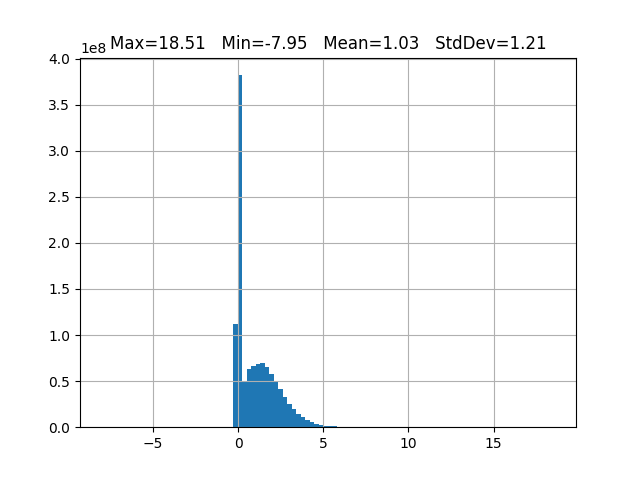

In [37]:
def plot_volume_histogram(volume,bins=100):
    
    maximum = np.max(volume)
    minimum = np.min(volume)
    mean    = np.mean(volume)
    stddev  = np.std(volume)
    
    fig, ax = plt.subplots()
    ax.hist(volume.flatten(),bins=bins)
    ax.grid()
    ax.set_title(f'Max={maximum:.2f}   Min={minimum:.2f}   Mean={mean:.2f}   StdDev={stddev:.2f}')
    
plot_volume_histogram(equalized_sinogram)

In [17]:
sscCdi.misc.deploy_visualizer(equalized_sinogram,title='sample',cmap='gray',axis=2)

In [ ]:
def plot_sinogram_slices(sinogram,cmap='gray'):
    shape = sinogram.shape
    fig, ax = plt.subplots(1,2,figsize=(20,5))
    ax[0].imshow(sinogram[:,shape[1]//2,:],cmap=cmap)
    ax[1].imshow(sinogram[:,:,shape[2]//2],cmap=cmap)    
    
plot_sinogram_slices(equalized_sinogram)

## Vertical mass fluctuation

In [ ]:
aligned_volume2 = alignment_vertical_mass_fluctuation(cropped_aligned_volume, use_phase_gradient = False, plot = True)

In [ ]:
sscCdi.misc.deploy_visualizer(np.angle(aligned_volume2),title='sample',cmap='gray')

In [ ]:
sscCdi.misc.deploy_visualizer(np.angle(aligned_volume2),title='sample',cmap='gray',axis=2)

In [ ]:
sscCdi.misc.deploy_visualizer(np.angle(cropped_aligned_volume),title='sample',cmap='gray',axis=2)

In [ ]:
unwrapped_volume = unwrap_in_parallel(np.angle(aligned_volume2))
unwrapped_volume = unwrapped_volume[:,100::,:]

sscCdi.misc.deploy_visualizer(unwrapped_volume,title='sample',cmap='gray')

In [24]:
dic = {}
dic["bad_frames_before_unwrap"] = []#[28,30,45,49,65,66,91,113]
dic["equalize_gradient"] = [True,[1400,1500,0,1500],0]
dic["equalize_global_offset"] = False
dic["equalize_invert"] = True
dic["equalize_local_offset"] = [1400,1500,0,1500]
dic["equalize_outliers"] = 0

# equalized_sinogram = equalize_frames_parallel(unwrapped_volume,dic["equalize_invert"],dic["equalize_gradient"],dic["equalize_outliers"],dic["equalize_global_offset"], dic["equalize_local_offset"])
# sscCdi.misc.deploy_visualizer(equalized_sinogram,title='sample',cmap='gray')

In [ ]:
sscCdi.misc.deploy_visualizer(equalized_sinogram,title='sample',cmap='gray',axis=2)

In [ ]:
sscCdi.misc.deploy_visualizer(equalized_sinogram,title='sample',cmap='gray',axis=1)